# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.optim as optim
from   torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

from collections import OrderedDict

## Helper Functions

In [2]:
def check_gpu():
    '''
        :None
        This function only serves to help the user understand if their machine is capable of running on the gpu
    '''

    # Check if GPU/CUDA capability is even possible with the downloaded version of torch

    # Verify that the GPU is available
    print("Torch version:",torch.__version__)
    print("Is CUDA enabled?",torch.cuda.is_available())

    return None

In [3]:
# check_gpu()

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
data_path = './'
batch_size = 64

# Define transforms
# transforms.RandomCrop(32, padding=4)

data_transform_train = transforms.Compose([transforms.RandomRotation(15),
                                           transforms.RandomHorizontalFlip(0.3),
                                           transforms.RandomVerticalFlip(0.3),
                                           transforms.RandomCrop(32,padding=4),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

data_transform_valid = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

data_transform_test = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

# Create training set
image_datasets_train = datasets.CIFAR10(data_path, train=True, download=True, transform=data_transform_train)

# Create validation set
val_size = int(0.1 * len(image_datasets_train))
train_size = len(image_datasets_train) - val_size
image_datasets_train, image_datasets_valid = torch.utils.data.random_split(image_datasets_train, [train_size, val_size])

image_datasets_valid.dataset.transform = data_transform_valid

# Dataloaders for train and valid datasets
dataloaders_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=batch_size, shuffle=True)
dataloaders_valid = torch.utils.data.DataLoader(image_datasets_valid, batch_size=batch_size)

# Create test set and define test dataloader
image_datasets_test  = datasets.CIFAR10(data_path, train=False, download=True, transform=data_transform_test)
dataloaders_test    = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_size)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

In [6]:
# Exploring an individual image
img, lab = image_datasets_valid[0]
img.shape

torch.Size([3, 32, 32])

Each of the images is 3 x 32 x 32. Where the 3 is a 3-channel RGB image and the 32x32 is the number of pixels for each image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


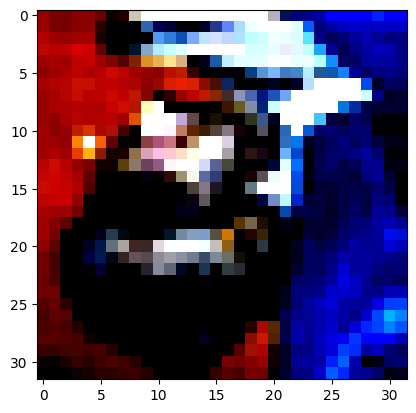

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


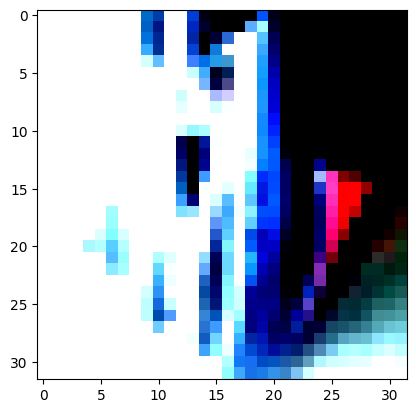

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


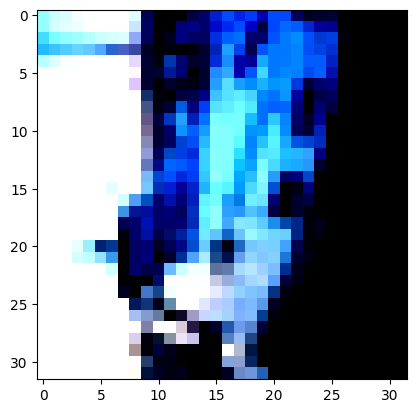

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


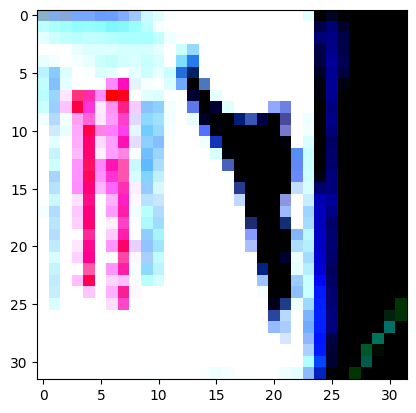

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


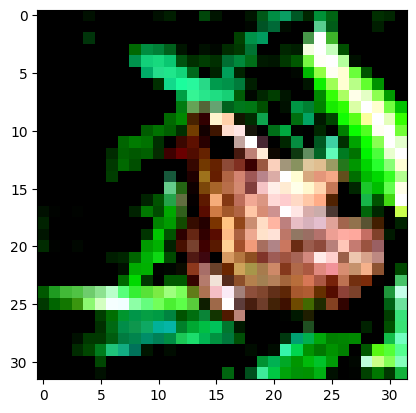

In [7]:
# Explore data
show5(dataloaders_test)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
## YOUR CODE HERE ##

# I am going to train an existing neural network from torchvision.models
# By using preexisting neural networks you can leverage a lot of computing power in order to train a vast majority of the weights
# and then alter the end of the neural network to fit the specific problem that you are working with

weightsvgg16 = models.VGG16_Weights.DEFAULT
vgg16 = models.vgg16(weights=weightsvgg16)

# Freeze Parameters so we don't back prop through them
for param in vgg16.parameters():
    param.requires_grad = False


classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 2500)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(2500, 1024)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('fc3', nn.Linear(1024,256)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('fc4', nn.Linear(256,10)),
    ('output1', nn.LogSoftmax(dim=1))
]))

# Now we need to assign this custom fully connected to our model
vgg16.classifier = classifier

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
## YOUR CODE HERE ##
# Since we are using a log softmax as the final output of our fully connected layer we need to use something like the NLLLoss() criterion
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
model = vgg16

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
## YOUR CODE HERE ##
path = "models/VGG16_BestModel_XYZ.pth"
epochs = 5
print_every = 10

# Move the model over to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Some initalizations required for training/validating
best_valid_loss = float('inf')
steps = 0
running_loss_train = 0

# Let's also add some lists so that we can track losses and accuracies
train_losses = []
valid_losses = []
valid_accuracy = []

# An epoch is defined as a single run through of the entire (training) set of data
for epoch in range(epochs):

    # Put the model into training
    model.train()

    # dataloaders_train contains 103 'passes' which accounts for ALL images/labels
    for images_train, labels_train in dataloaders_train:

        # Increment the steps for nice readouts
        steps += 1

        # Move things over to the GPU!
        images_train =  images_train.to(device)
        labels_train =  labels_train.to(device)

        # The classic pattern
        optimizer.zero_grad()
        logps = model(images_train)
        loss = criterion(logps, labels_train)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

        if steps % print_every == 0:

            # Put the model into eval mode
            model.eval()

            with torch.no_grad():

                running_loss_valid = 0
                accuracy_valid = 0
                
                for images_valid, labels_valid in dataloaders_valid:

                    # Move things over the GPU!
                    images_valid = images_valid.to(device)
                    labels_valid = labels_valid.to(device)

                    logps      = model(images_valid)
                    valid_loss = criterion(logps, labels_valid)
                    running_loss_valid += valid_loss.item()

                    # Calculate Accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equal = top_class == labels_valid.view(*top_class.shape)
                    accuracy_valid += torch.mean(equal.type(torch.FloatTensor)).item()

            rlt = running_loss_train/print_every
            rlv = running_loss_valid/len(dataloaders_valid)
            acc = accuracy_valid/len(dataloaders_valid)
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {rlt:.3f}.. "
                    f"Valid loss: {rlv:.3f}.. "
                    f"Valid accuracy: {acc:.3f}")
            
            train_losses.append(rlt)
            valid_losses.append(rlv)
            valid_accuracy.append(acc)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss

                torch.save(model.state_dict(), path)
            
            # Reinitialize the running_loss to be 0 for the new epoch
            running_loss_train = 0

Epoch 1/5.. Train loss: 2.285.. Valid loss: 1.580.. Valid accuracy: 0.426
Epoch 1/5.. Train loss: 1.638.. Valid loss: 1.440.. Valid accuracy: 0.487
Epoch 1/5.. Train loss: 1.372.. Valid loss: 1.276.. Valid accuracy: 0.565
Epoch 1/5.. Train loss: 1.268.. Valid loss: 1.215.. Valid accuracy: 0.582
Epoch 1/5.. Train loss: 1.208.. Valid loss: 1.191.. Valid accuracy: 0.583
Epoch 1/5.. Train loss: 1.303.. Valid loss: 1.215.. Valid accuracy: 0.583
Epoch 1/5.. Train loss: 1.189.. Valid loss: 1.189.. Valid accuracy: 0.595
Epoch 1/5.. Train loss: 1.084.. Valid loss: 1.216.. Valid accuracy: 0.590
Epoch 1/5.. Train loss: 1.136.. Valid loss: 1.219.. Valid accuracy: 0.593
Epoch 1/5.. Train loss: 1.207.. Valid loss: 1.181.. Valid accuracy: 0.594
Epoch 1/5.. Train loss: 1.181.. Valid loss: 1.104.. Valid accuracy: 0.627
Epoch 1/5.. Train loss: 1.163.. Valid loss: 1.161.. Valid accuracy: 0.593
Epoch 1/5.. Train loss: 1.160.. Valid loss: 1.155.. Valid accuracy: 0.609
Epoch 1/5.. Train loss: 1.204.. Valid 

Plot the training loss (and validation loss/accuracy, if recorded).

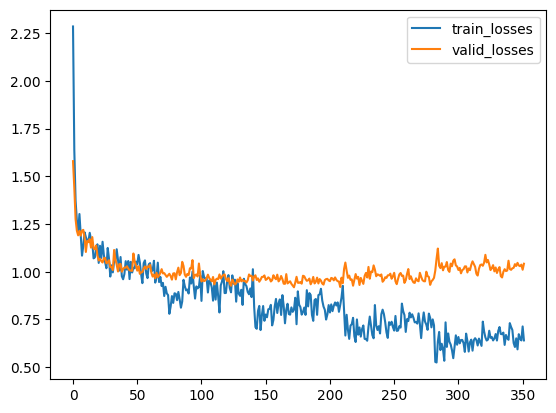

In [11]:
## YOUR CODE HERE ##

plt.plot(train_losses, label='train_losses')
plt.plot(valid_losses, label='valid_losses')
plt.legend()
plt.show()


I am utilizing regularization techniques like dropout and data augmentation but it seems like as the number of epochs grow in the trianing set the training loss takes these abrupt steps down in loss.. I am not really sure what is going on here and would love some help understanding.

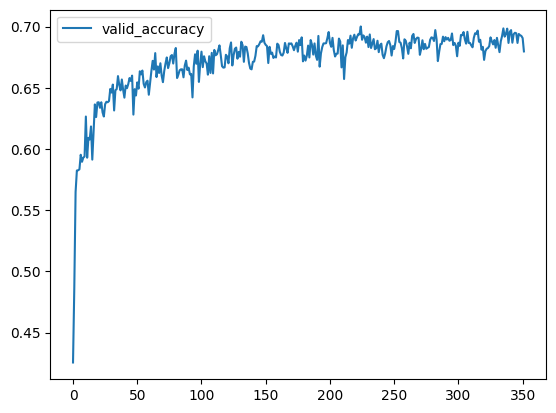

In [12]:
plt.plot(valid_accuracy, label='valid_accuracy')
plt.legend()
plt.show()

The accuracy appears to grow steadily and then approach an asymoptote around 70% which is what our benchmark algorithm was able to achieve.

In [13]:
max(valid_accuracy)

0.7001582278481012

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [19]:
state_dict = torch.load('models/VGG16_BestModel_XYZ.pth')
model = vgg16
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

with torch.no_grad():
    running_test_loss = 0
    test_accuracy = 0
    for images_test, labels_test in dataloaders_test:

        # Move things over the GPU!
        images_test = images_test.to(device)
        labels_test = labels_test.to(device)

        logps = model(images_test)
        test_loss = criterion(logps, labels_test)
        running_test_loss += test_loss.item()

        # Calculate Accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equal = top_class == labels_test.view(*top_class.shape)
        test_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(dataloaders_test):.3f}")

Test accuracy: 0.672


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
# Saved Model in the training section after validation was performed
# Saved models go into the "models" folder where they can be accessed

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The model that I chose to implement was a VGG16 model where the fully connected layer at the end was modified for our scenario. VGG16 is a type of convolutional neural network (CNN) that is very popular with images as it preserves some local structure in the images. I felt that any kind of CNN was approparite for adapting for this project including VGG16 and Resnet50 however Resnet50 is not shown in this notebook as I was getting very low accuracies with that type of model.

The model that I was able to adapt to the CIFAR-10 dataset achieved 67.2% accuracy whereas the model that we could purchase for this scenario claims to be able to achieve 70%. With the accuracies of Detectocorp and my algorithm being so close it is difficult to say definitively if we should purchase the algorithm or not. It seems like building a model in house produces accuracies that are on the same level as our purchasable option and with more fine tuning it may be possible to increase our accuracy to some threshold that we deem acceptable.